In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *
from evaluation.metrics import *

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, Dropout, BatchNormalization

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-14 12:11:03.517199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:11:03.521009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:11:03.521165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Generate `Time`

In [4]:
data_with_time = generate_full_timestamp(data)

## 2) Imputing

In [5]:
data_imp = data_with_time.fillna(method='bfill')

## 3) Feature engineering

In [6]:
data_proc = preprocess(data_imp)
data_proc_clean = data_proc.copy()

In [7]:
data_proc

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time_in_day,Time,locX,locY,TimeX,TimeY,DayX,DayY,Etmp_abs,Wdir_adj,Wdir_cos,Wdir_sin,Ndir_cos,Ndir_sin,WdirX,WdirY,NdirX,NdirY,WspdX,WspdY,WspdX_abs,WspdY_abs,TSR1,TSR2,TSR3,Bspd1,Bspd2,Bspd3,RPM,Pab,TSR,Wspd_cube,P_max,Papt,Patan
0,1,1,0.000000,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,1,1,3349.8515,5939.23193,1.000000,0.000000,0.999852,0.017202,273.88,0.382751,0.927641,0.373474,0.899405,0.437116,0.927641,0.373474,0.999969,0.007896,6.155045,-0.429323,5.723544,2.304332,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,1.00,2.605089,233.181313,0.857621,494.660063,-0.000505
1,1,1,0.166667,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2,2,3349.8515,5939.23193,0.999048,0.043619,0.999852,0.017202,273.88,0.382751,0.927641,0.373474,0.899405,0.437116,0.927641,0.373474,0.999969,0.007896,6.155045,-0.429323,5.723544,2.304332,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,1.00,2.605089,233.181313,0.857621,494.660063,-0.000505
2,1,1,0.333333,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3,3,3349.8515,5939.23193,0.996195,0.087156,0.999852,0.017202,273.75,0.326900,0.947042,0.321109,0.934142,0.356901,0.947042,0.321109,0.999980,0.006370,6.265462,-0.238505,5.937955,2.013353,2.605089,2.605089,2.605089,16.322087,16.322087,16.322087,16.322087,1.00,2.605089,245.957079,0.900427,509.760056,-0.000471
3,1,1,0.500000,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,4,4,3349.8515,5939.23193,0.991445,0.130526,0.999852,0.017202,273.67,0.352207,0.938613,0.344971,0.934142,0.356901,0.938613,0.344971,0.999980,0.006370,6.419479,-0.081794,6.025899,2.214711,2.605089,2.605089,2.605089,16.723314,16.723314,16.723314,16.723314,1.00,2.605089,264.544863,0.966892,542.530062,-0.000479
4,1,1,0.666667,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,5,5,3349.8515,5939.23193,0.984808,0.173648,0.999852,0.017202,273.64,0.380482,0.928486,0.371368,0.934142,0.356901,0.928486,0.371368,0.999980,0.006370,6.249246,0.097080,5.803036,2.321049,2.605089,2.605089,2.605089,16.279842,16.279842,16.279842,16.279842,1.00,2.605089,244.052275,0.892196,509.360052,-0.000452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23.166667,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,140,28796,11.3385,6713.46517,0.976296,-0.216440,-0.955642,-0.294529,252.19,3.125361,-0.999868,0.016231,-0.995210,0.097757,-0.999868,0.016231,0.998589,0.053097,4.843796,0.396530,-4.859360,0.078882,2.745986,2.745986,2.745986,13.300998,13.300998,13.300998,13.300998,0.01,2.745986,113.646913,0.455178,327.042687,-0.336971
3859196,134,200,23.333333,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,141,28797,11.3385,6713.46517,0.984808,-0.173648,-0.955642,-0.294529,251.94,3.067591,-0.997263,0.073934,-0.999991,0.004189,-0.997263,0.073934,0.998501,0.054731,4.449136,-0.311114,-4.447793,0.329748,2.745986,2.745986,2.745986,12.217265,12.217265,12.217265,12.217265,0.01,2.745986,88.069787,0.352134,240.572254,-0.399805
3859197,134,200,23.500000,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,142,28798,11.3385,6713.46517,0.991445,-0.130526,-0.955642,-0.294529,251.89,3.006679,-0.990913,0.134505,-0.991100,0.133121,-0.990913,0.134505,0.998622,0.052477,4.229996,-0.005906,-4.191562,0.568956,2.745986,2.745986,2.745986,11.615510,11.615510,11.615510,11.615510,0.01,2.745986,75.686746,0.300476,247.042102,-0.466906
3859198,134,200,23.666667,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,143,28799,11.3385,6713.46517,0.996195,-0.087156,-0.955642,-0.294529,251.79,2.901261,-0.971259,0.238025,-0.991100,0.133121,-0.971259,0.238025,0.998622,0.052477,4.335151,-0.464825,-4.234689,1.037789,2.745986,2.745986,2.745986,11.904266,11.904266,11.904266,11.904266,0.01,2.745986,81.472834,0.329171,247.028873,-0.45

## 4) Select features

In [8]:
cols = select_features(data_proc)

## 5) Mark anomalies

In [9]:
MARKING_VALUE = -9999
data_anom = marking_data(data_proc, MARKING_VALUE)
data_anom

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time_in_day,Time,locX,locY,TimeX,TimeY,DayX,DayY,Etmp_abs,Wdir_adj,Wdir_cos,Wdir_sin,Ndir_cos,Ndir_sin,WdirX,WdirY,NdirX,NdirY,WspdX,WspdY,WspdX_abs,WspdY_abs,TSR1,TSR2,TSR3,Bspd1,Bspd2,Bspd3,RPM,Pab,TSR,Wspd_cube,P_max,Papt,Patan
0,1,1,0.000000,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,1,1,3349.8515,5939.23193,1.000000,0.000000,0.999852,0.017202,273.88,0.382751,0.927641,0.373474,0.899405,0.437116,0.927641,0.373474,0.999969,0.007896,6.155045,-0.429323,5.723544,2.304332,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,1.00,2.605089,233.181313,0.857621,494.660063,-0.000505
1,1,1,0.166667,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2,2,3349.8515,5939.23193,0.999048,0.043619,0.999852,0.017202,273.88,0.382751,0.927641,0.373474,0.899405,0.437116,0.927641,0.373474,0.999969,0.007896,6.155045,-0.429323,5.723544,2.304332,2.605089,2.605089,2.605089,16.034441,16.034441,16.034441,16.034441,1.00,2.605089,233.181313,0.857621,494.660063,-0.000505
2,1,1,0.333333,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3,3,3349.8515,5939.23193,0.996195,0.087156,0.999852,0.017202,273.75,0.326900,0.947042,0.321109,0.934142,0.356901,0.947042,0.321109,0.999980,0.006370,6.265462,-0.238505,5.937955,2.013353,2.605089,2.605089,2.605089,16.322087,16.322087,16.322087,16.322087,1.00,2.605089,245.957079,0.900427,509.760056,-0.000471
3,1,1,0.500000,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,4,4,3349.8515,5939.23193,0.991445,0.130526,0.999852,0.017202,273.67,0.352207,0.938613,0.344971,0.934142,0.356901,0.938613,0.344971,0.999980,0.006370,6.419479,-0.081794,6.025899,2.214711,2.605089,2.605089,2.605089,16.723314,16.723314,16.723314,16.723314,1.00,2.605089,264.544863,0.966892,542.530062,-0.000479
4,1,1,0.666667,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,5,5,3349.8515,5939.23193,0.984808,0.173648,0.999852,0.017202,273.64,0.380482,0.928486,0.371368,0.934142,0.356901,0.928486,0.371368,0.999980,0.006370,6.249246,0.097080,5.803036,2.321049,2.605089,2.605089,2.605089,16.279842,16.279842,16.279842,16.279842,1.00,2.605089,244.052275,0.892196,509.360052,-0.000452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23.166667,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,140,28796,11.3385,6713.46517,0.976296,-0.216440,-0.955642,-0.294529,252.19,3.125361,-0.999868,0.016231,-0.995210,0.097757,-0.999868,0.016231,0.998589,0.053097,4.843796,0.396530,-4.859360,0.078882,2.745986,2.745986,2.745986,13.300998,13.300998,13.300998,13.300998,0.01,2.745986,113.646913,0.455178,327.042687,-0.336971
3859196,134,200,23.333333,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,141,28797,11.3385,6713.46517,0.984808,-0.173648,-0.955642,-0.294529,251.94,3.067591,-0.997263,0.073934,-0.999991,0.004189,-0.997263,0.073934,0.998501,0.054731,4.449136,-0.311114,-4.447793,0.329748,2.745986,2.745986,2.745986,12.217265,12.217265,12.217265,12.217265,0.01,2.745986,88.069787,0.352134,240.572254,-0.399805
3859197,134,200,23.500000,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,142,28798,11.3385,6713.46517,0.991445,-0.130526,-0.955642,-0.294529,251.89,3.006679,-0.990913,0.134505,-0.991100,0.133121,-0.990913,0.134505,0.998622,0.052477,4.229996,-0.005906,-4.191562,0.568956,2.745986,2.745986,2.745986,11.615510,11.615510,11.615510,11.615510,0.01,2.745986,75.686746,0.300476,247.042102,-0.466906
3859198,134,200,23.666667,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,143,28799,11.3385,6713.46517,0.996195,-0.087156,-0.955642,-0.294529,251.79,2.901261,-0.971259,0.238025,-0.991100,0.133121,-0.971259,0.238025,0.998622,0.052477,4.335151,-0.464825,-4.234689,1.037789,2.745986,2.745986,2.745986,11.904266,11.904266,11.904266,11.904266,0.01,2.745986,81.472834,0.329171,247.028873,-0.45

In [10]:
data_sel = data_anom[cols]
data_sel

,TurbID,Time,TSR3,TSR2,TSR,TSR1,Pab3,Pab2,Pab,Pab1,P_max,Patan,Wspd_cube,Wspd,WspdX,Bspd2,Bspd3,Bspd1,RPM,Papt,Patv
0,1,1,2.605089,2.605089,2.605089,2.605089,1.00,1.00,1.00,1.00,0.857621,-0.000505,233.181313,6.17,6.155045,16.034441,16.034441,16.034441,16.034441,494.660063,494.66
1,1,2,2.605089,2.605089,2.605089,2.605089,1.00,1.00,1.00,1.00,0.857621,-0.000505,233.181313,6.17,6.155045,16.034441,16.034441,16.034441,16.034441,494.660063,494.66
2,1,3,2.605089,2.605089,2.605089,2.605089,1.00,1.00,1.00,1.00,0.900427,-0.000471,245.957079,6.27,6.265462,16.322087,16.322087,16.322087,16.322087,509.760056,509.76
3,1,4,2.605089,2.605089,2.605089,2.605089,1.00,1.00,1.00,1.00,0.966892,-0.000479,264.544863,6.42,6.419479,16.723314,16.723314,16.723314,16.723314,542.530062,542.53
4,1,5,2.605089,2.605089,2.605089,2.605089,1.00,1.00,1.00,1.00,0.892196,-0.000452,244.052275,6.25,6.249246,16.279842,16.279842,16.279842,16.279842,509.360052,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,28796,2.745986,2.745986,2.745986,2.745986,0.01,0.01,0.01,0.01,0.455178,-0.336971,113.646913,4.86,4.843796,13.300998,13.300998,13.300998,13.300998,327.042687,308.65
3859196,134,28797,2.745986,2.745986,2.745986,2.745986,0.01,0.01,0.01,0.01,0.352134,-0.399805,88.069787,4.46,4.449136,12.217265,12.217265,12.217265,12.217265,240.572254,221.60
3859197,134,28798,2.745986,2.745986,2.745986,2.745986,0.01,0.01,0.01,0.01,0.300476,-0.466906,75.686746,4.23,4.229996,11.615510,11.615510,11.615510,11.615510,247.042102,220.60
3859198,134,28799,2.745986,2.745986,2.745986,2.745986,0.01,0.01,0.01,0.01,0.329171,-0.452658,81.472834,4.36,4.335151,11.904266,11.904266,11.904266,11.904266,247.028873,222.15


## 5) Split dataset

In [11]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = False
TEST_SIZE   = 0.2
BATCH_SIZE  = 256

In [12]:
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_sel, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)
train_x_clean, train_y_clean, val_x_clean, val_y_clean, test_x_clean = make_train_val_test_data(data_proc_clean[cols], IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

100%|██████████| 134/134 [00:11<00:00, 12.00it/s]


Train data(X, y)     : (21038, 288, 19) (21038, 288, 19)
Validation data(X, y): (5360, 288, 19) (5360, 288, 19)
Test data(X)         : (134, 288, 19)


100%|██████████| 134/134 [00:10<00:00, 12.39it/s]


Train data(X, y)     : (21038, 288, 19) (21038, 288, 19)
Validation data(X, y): (5360, 288, 19) (5360, 288, 19)
Test data(X)         : (134, 288, 19)


In [13]:
train_ds = generate_dataset(train_x_clean, train_y, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x_clean, val_y, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_clean, batch_size=1)

2022-07-14 12:11:58.418138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 12:11:58.418995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:11:58.419153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:11:58.419251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 3. Modeling

In [14]:
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential([
    Input(shape=(train_x.shape[1],train_x.shape[2])),
    Bidirectional(GRU(units=256)),
    RepeatVector(train_y.shape[1]),
    Bidirectional(GRU(units=256, return_sequences=True)),
    TimeDistributed(Dense(units=train_x.shape[-1]))
])
model.compile(optimizer='adam', loss=CondLoss('rmse', MARKING_VALUE), metrics=[RootMeanSquaredError(), 'mae'])
# model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'], loss_weights=None)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 512)              425472    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 288, 512)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 288, 19)          9747      
 ibuted)                                                         
                                                                 
Total params: 1,617,939
Trainable params: 1,617,939
Non-

# 4. Training

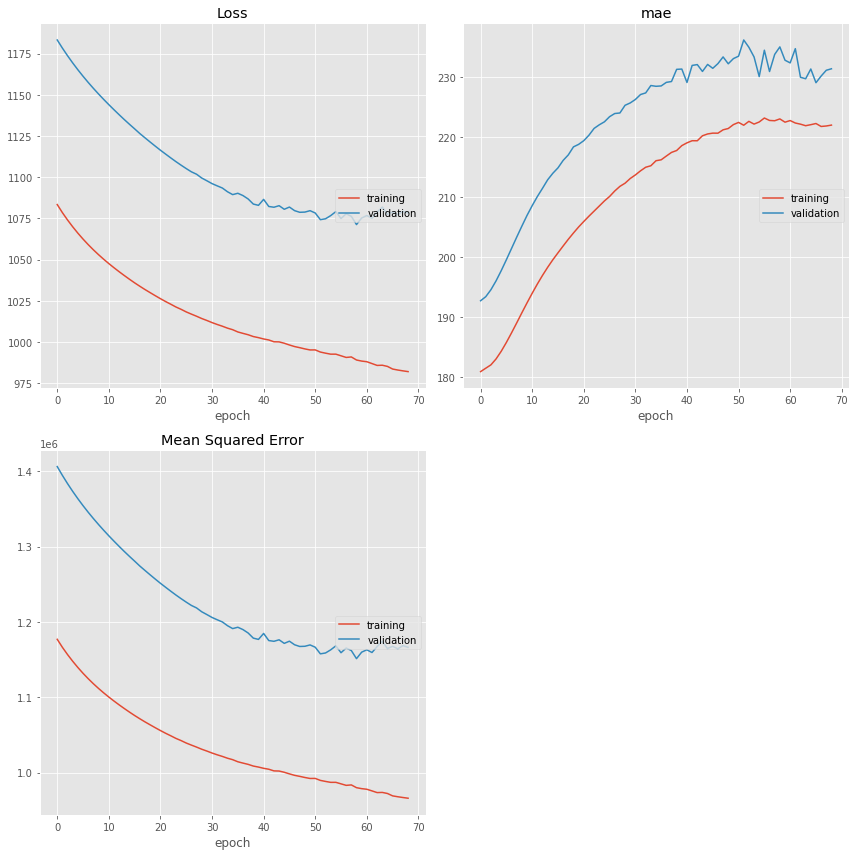

Loss
	training         	 (min:  981.976, max: 1083.385, cur:  981.976)
	validation       	 (min: 1071.226, max: 1183.280, cur: 1078.240)
mae
	training         	 (min:  180.969, max:  223.201, cur:  222.021)
	validation       	 (min:  192.770, max:  236.198, cur:  231.402)
Mean Squared Error
	training         	 (min: 965838.625, max: 1176924.375, cur: 965838.625)
	validation       	 (min: 1151216.875, max: 1406353.500, cur: 1166301.750)
83/83 [==============================] - 7s 89ms/step - loss: 981.9763 - mse: 965838.6250 - mae: 222.0211 - val_loss: 1078.2395 - val_mse: 1166301.7500 - val_mae: 231.4018 - lr: 5.9049e-04


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

model.fit(train_ds, validation_data=val_ds, epochs=1000,
          callbacks=[
              PlotLossesKeras(),
              EarlyStopping(patience=10, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

# 5. Check results

## 1) Training set

658/658 [==============================] - 19s 28ms/step


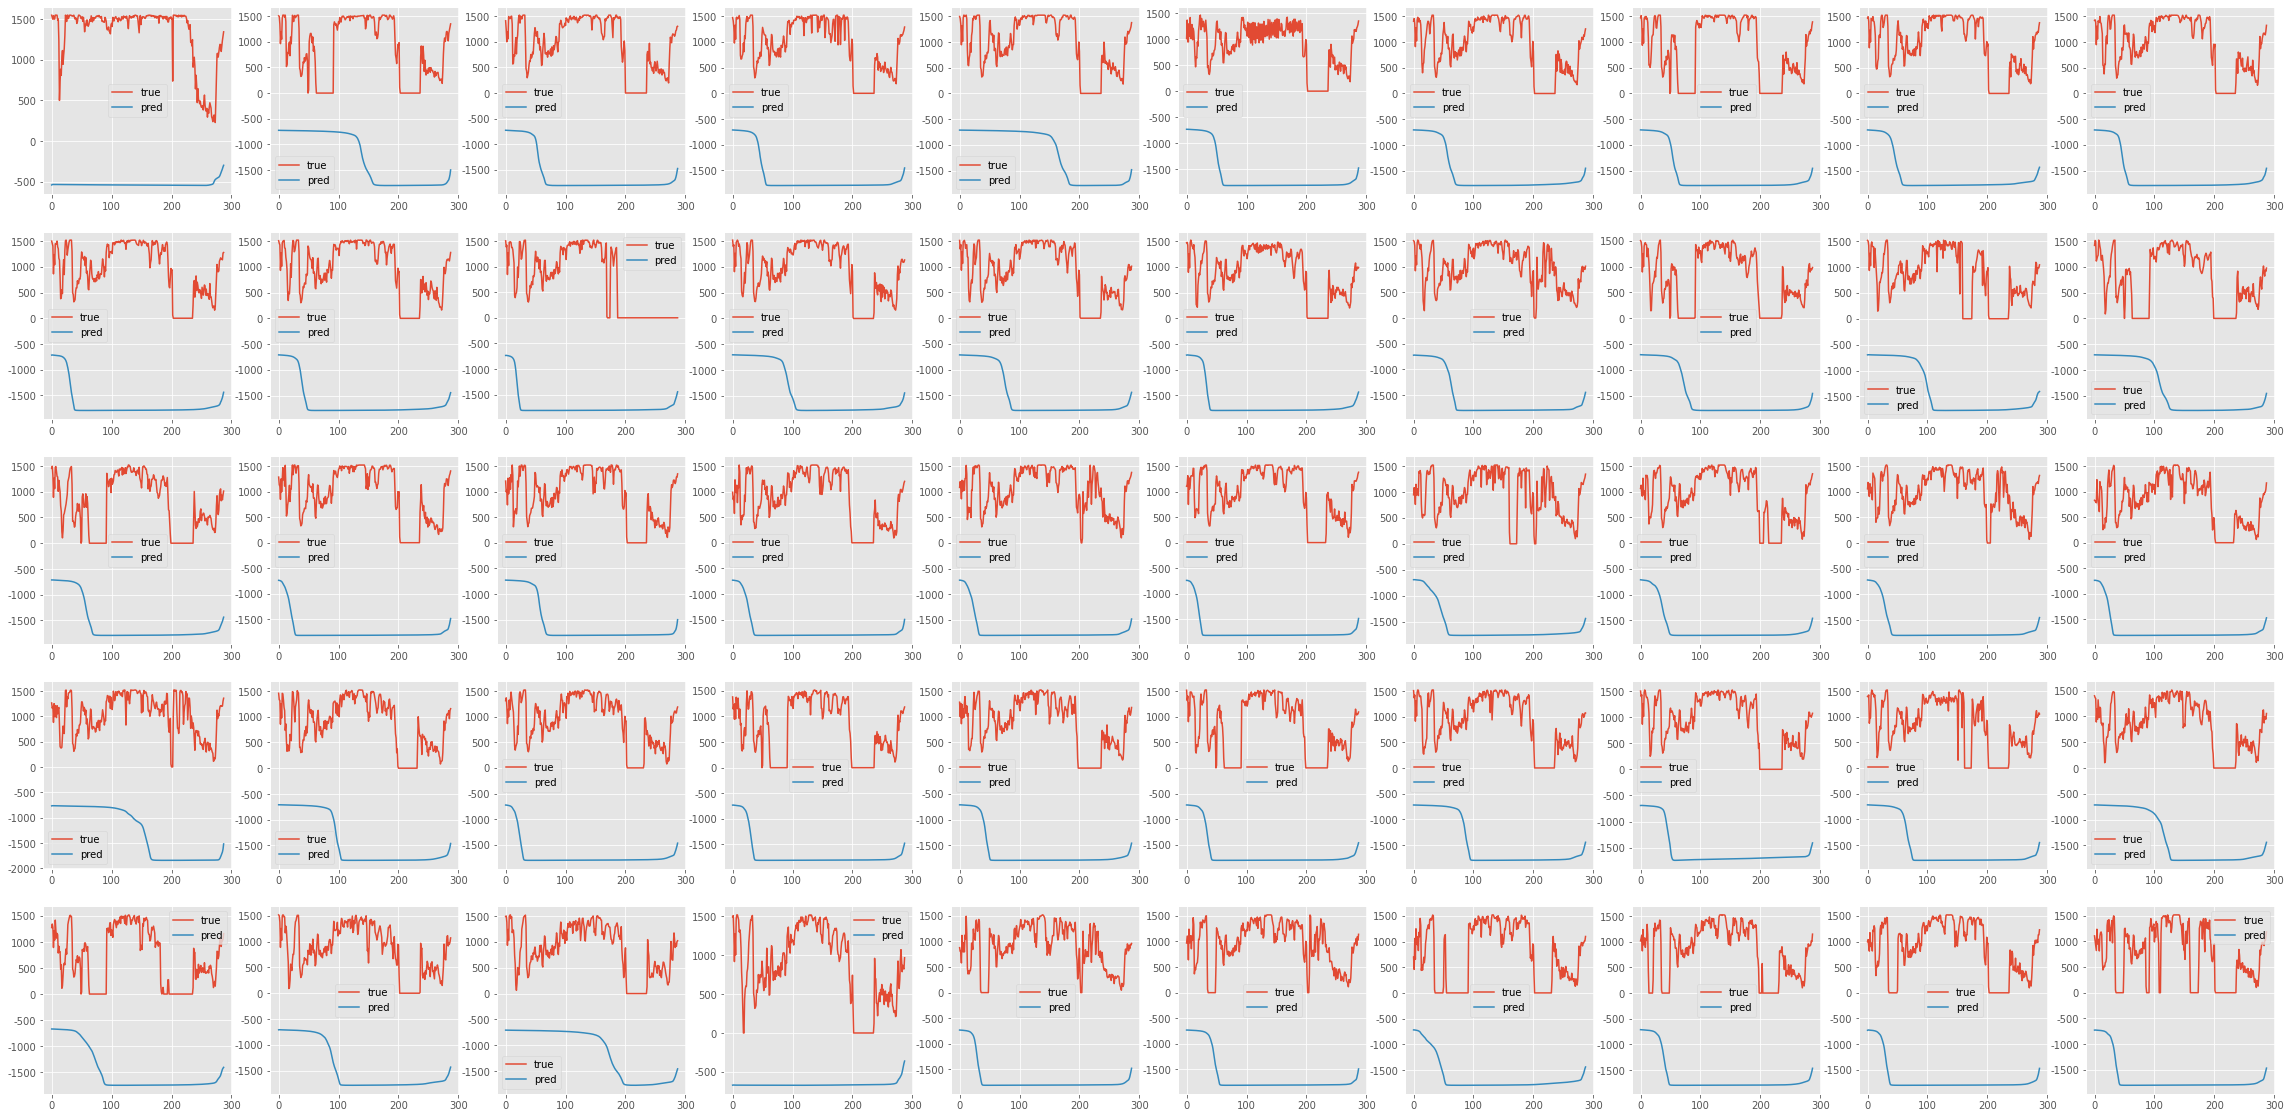

In [16]:
y_true = train_y_clean[:, :, -1]
y_pred = model.predict(train_x_clean)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

## 2) Validation set

168/168 [==============================] - 5s 27ms/step


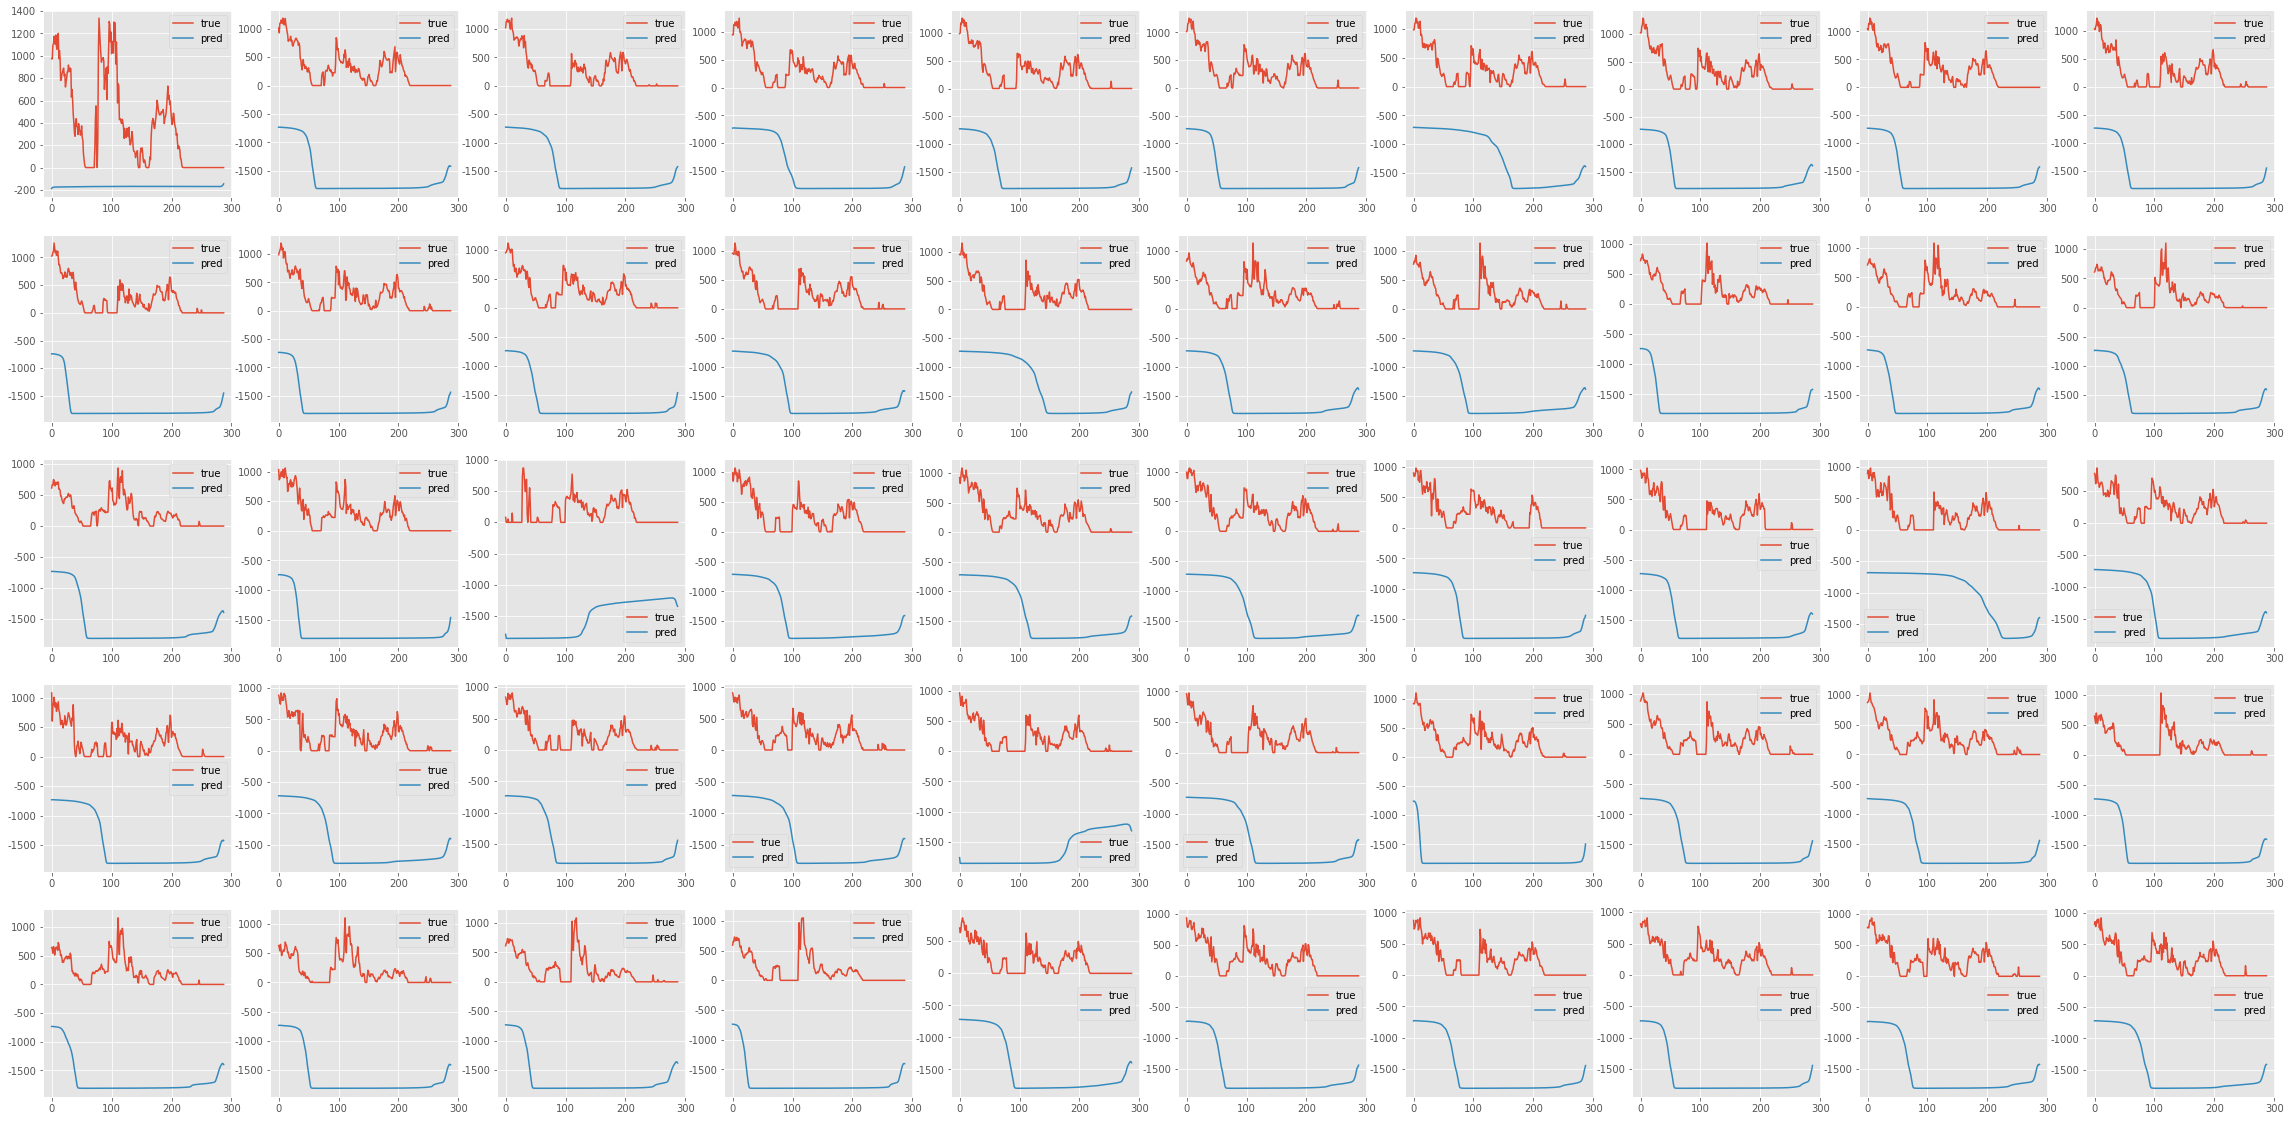

In [17]:
y_true = val_y_clean[:, :, -1]
y_pred = model.predict(val_x_clean)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# 6. Generate submission

In [18]:
sample_submission['Patv'] = model.predict(test_x)[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed13.csv"), index=False)

5/5 [==============================] - 0s 25ms/step
